In [35]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from pytrends.request import TrendReq
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta

color_palette = sns.color_palette("Spectral", n_colors=7, desat=0.75)
sns.set_palette(color_palette)
plt.style.use("Solarize_Light2")

eth = yf.Ticker("ETH-USD")

In [28]:
today = datetime.now()
start_date = today - timedelta(days=728)
trends_data = pd.read_csv("Datasets/multiTimeline.csv")
trends_data = trends_data.drop(trends_data.index[0])
trends_data["goog_trend"] = pd.to_numeric(
    trends_data["Category: All categories"], errors="coerce"
)
trends_data.index = pd.to_datetime(trends_data.index).tz_localize(None)
trends_data = trends_data[["goog_trend"]].resample("H").interpolate(method="linear")
df = eth.history(start=start_date, end=today, interval="1h")
df.index = pd.to_datetime(df.index).tz_localize(None)
del df["Dividends"]
del df["Stock Splits"]
del df["Volume"]
df.columns = [c.lower() for c in df.columns]
df["pct_chg_hour_before"] = df["close"].pct_change(periods=-1)
df["4_hr_future"] = df["close"].shift(-4)
df["target"] = (df["4_hr_future"] > df["close"]).astype(int)
df = df.merge(trends_data, left_index=True, right_index=True, how="left")
df

,open,high,low,close,pct_chg_hour_before,4_hr_future,target,goog_trend
Datetime,,,,,,,,
2022-01-07 12:00:00,3228.573242,3257.580322,3228.573242,3245.648682,0.021238,3204.604492,0,95.285714
2022-01-07 13:00:00,3245.313232,3252.154785,3170.303955,3178.152588,-0.011820,3195.822021,1,95.250000
2022-01-07 14:00:00,3177.586670,3217.196533,3174.723145,3216.168945,0.024105,3175.722168,0,95.214286
2022-01-07 15:00:00,3214.919434,3214.919434,3119.656250,3140.467773,-0.020014,3193.135742,1,95.178571
2022-01-07 16:00:00,3139.635742,3204.604492,3117.381348,3204.604492,0.002748,3217.130127,1,95.142857
...,...,...,...,...,...,...,...,...
2024-01-05 08:00:00,2255.378418,2260.166260,2252.748779,2254.207275,-0.004730,2246.761230,0,NaN
2024-01-05 09:00:00,2254.366943,2269.709961,2254.366943,2264.919678,0.010237,NaN,0,NaN
2024-01-05 10:00:00,2266.395752,2266.620605,2241.968262,2241.968262,-0.000786,NaN,0,NaN


<Axes: xlabel='Datetime'>

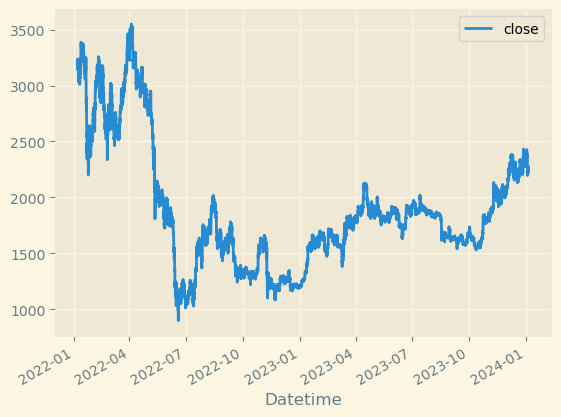

In [29]:
df.plot.line(y="close", use_index=True)

In [30]:
df["target"].value_counts()

target
1    8818
0    8630
Name: count, dtype: int64

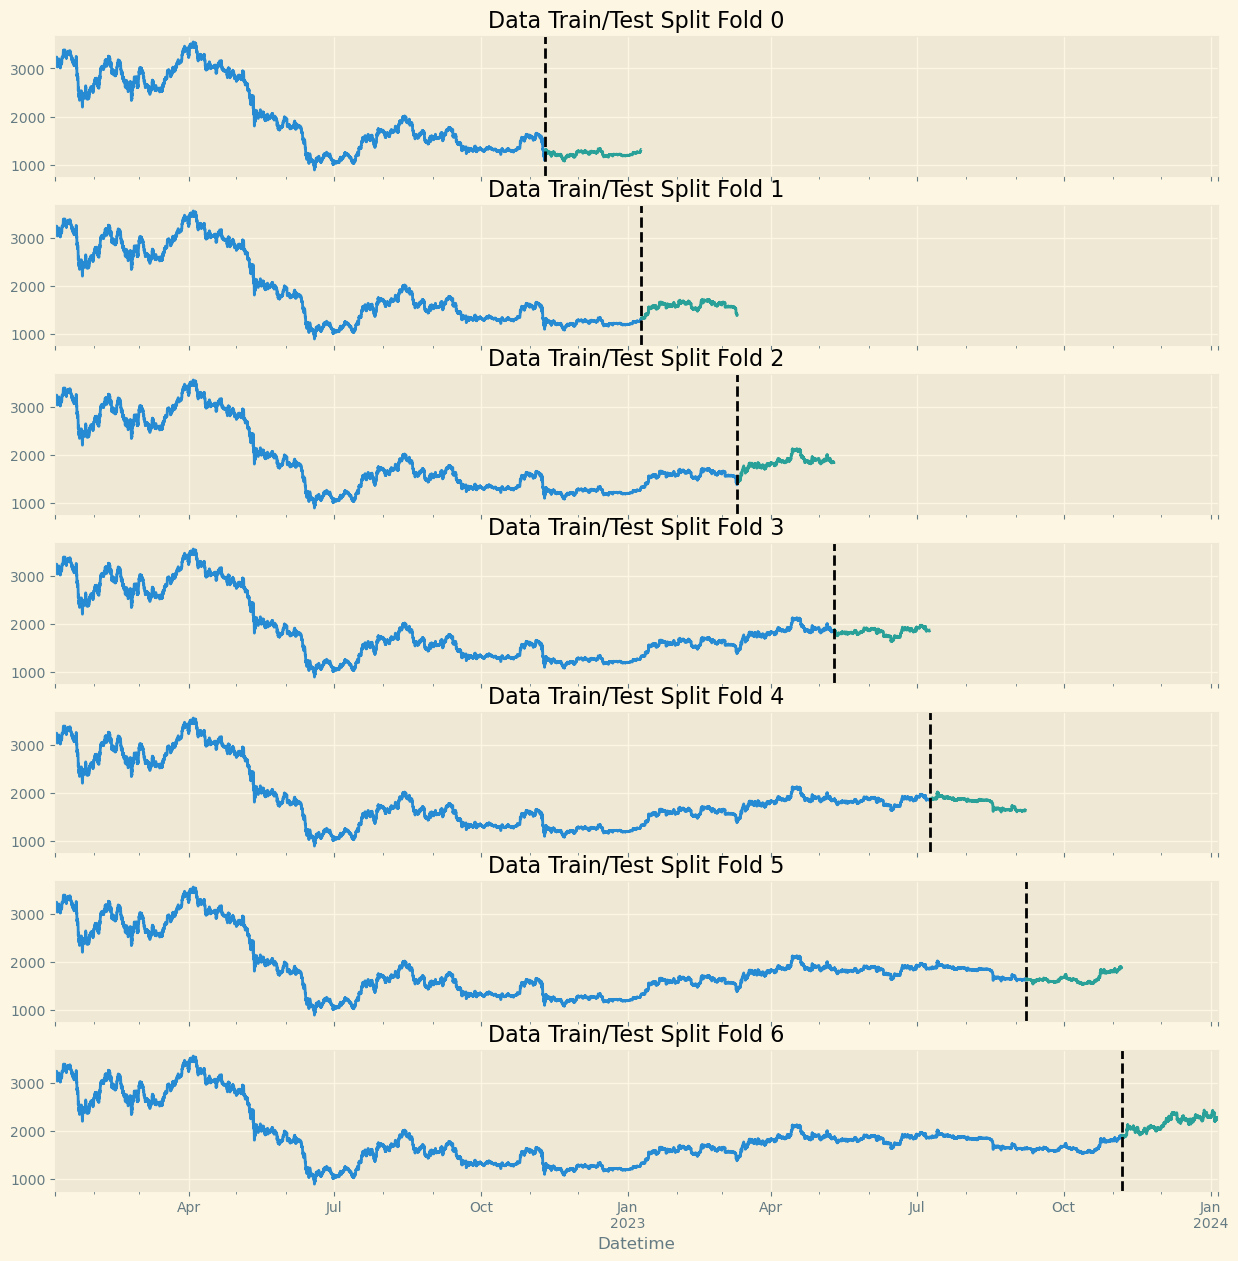

In [31]:
tss = TimeSeriesSplit(n_splits=7, test_size=24 * 60, gap=1)
df = df.sort_index()

fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["close"].plot(
        ax=axs[fold], label="Training Set", title=f"Data Train/Test Split Fold {fold}"
    )
    test["close"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [32]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df


def add_lags(df):
    target_map = df["close"].to_dict()
    # 364 maps to the same day of the week
    df["lag1"] = (df.index - pd.Timedelta("4 hours")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("12 hours")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("24 hours")).map(target_map)
    df["lag4"] = (df.index - pd.Timedelta("2 days")).map(target_map)
    df["lag5"] = (df.index - pd.Timedelta("5 days")).map(target_map)
    df["lag6"] = (df.index - pd.Timedelta("6 days")).map(target_map)
    return df


df = add_lags(df)
df = create_features(df)
df.columns

Index(['open', 'high', 'low', 'close', 'pct_chg_hour_before', '4_hr_future',
       'target', 'goog_trend', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6',
       'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [37]:
df.dtypes

open                   float64
high                   float64
low                    float64
close                  float64
pct_chg_hour_before    float64
4_hr_future            float64
target                   int64
goog_trend             float64
lag1                   float64
lag2                   float64
lag3                   float64
lag4                   float64
lag5                   float64
lag6                   float64
hour                     int32
dayofweek                int32
quarter                  int32
month                    int32
year                     int32
dayofyear                int32
dayofmonth               int32
weekofyear              UInt32
dtype: object

In [38]:
tss = TimeSeriesSplit(n_splits=7, test_size=24 * 60, gap=1)
df = df.sort_index()
df = df.astype('float64')

FEATURES = [
    "open",
    "high",
    "low",
    "close",
    "pct_chg_hour_before",
    "goog_trend",
    "lag1",
    "lag2",
    "lag3",
    "lag4",
    "lag5",
    "lag6",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
]
TARGET = "target"

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Classifier
    classifier = xgb.XGBClassifier(random_state=69, learning_rate=0.001, n_estimators=1000)
    classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    # Predictions
    y_pred = classifier.predict(X_test)
    preds.append(y_pred)

    # Scoring
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    scores.append((accuracy, f1))

# Display scores
for i, score in enumerate(scores):
    print(f"Fold {i}: Accuracy = {score[0]}, F1 Score = {score[1]}")

[0]	validation_0-logloss:0.69294	validation_1-logloss:0.69305
[100]	validation_0-logloss:0.67408	validation_1-logloss:0.68364
[200]	validation_0-logloss:0.65830	validation_1-logloss:0.67688
[300]	validation_0-logloss:0.64485	validation_1-logloss:0.67311
[400]	validation_0-logloss:0.63301	validation_1-logloss:0.66832
[500]	validation_0-logloss:0.62286	validation_1-logloss:0.66272
[600]	validation_0-logloss:0.61402	validation_1-logloss:0.65708
[700]	validation_0-logloss:0.60614	validation_1-logloss:0.65631
[800]	validation_0-logloss:0.59915	validation_1-logloss:0.65537
[900]	validation_0-logloss:0.59274	validation_1-logloss:0.65548
[999]	validation_0-logloss:0.58720	validation_1-logloss:0.65594
[0]	validation_0-logloss:0.69295	validation_1-logloss:0.69304
[100]	validation_0-logloss:0.67453	validation_1-logloss:0.68283
[200]	validation_0-logloss:0.65906	validation_1-logloss:0.67500
[300]	validation_0-logloss:0.64597	validation_1-logloss:0.66767
[400]	validation_0-logloss:0.63468	validatio

In [39]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores:{scores}")

Score across folds 0.6182
Fold scores:[(0.5916666666666667, 0.42352941176470593), (0.6305555555555555, 0.6099706744868035), (0.6458333333333334, 0.5819672131147541), (0.6534722222222222, 0.6228269085411943), (0.6611111111111111, 0.6169544740973313), (0.6576388888888889, 0.6096595407759303), (0.6770833333333334, 0.6718419195483415)]
